<a href="https://www.kaggle.com/code/pachecopacheco4/houses-prices-1-0?scriptVersionId=149325909" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Brief intro

 On this ocassion we basically tried to automatize the features selection. In total there were almost 80 variables to take in account. For this reason our approach this time was the following:
 
 1. Make numeric features selection by calculating mutual information scores. The ones that were strictly lower from 0.05 were ommited.
 2. The same with categorical variables. 
 3. Preprocess categorical data from cleaned data: we had to restrict the possible levels of training set categorical variables (in order that when the time of fitting the model we have the same number of "columns" when we one hot encode them).
 4. To tune models this ocassion we not divide our training set in train/validation but we used the CV grid search optimal combination method. 

 **TODO**: this approach was basically a little bit mechanic; there is room for improvemen likely by:
 
 - Feature engineering. 
 - Trying to use statistical regression methods. 
 
  Nevertheless, we think that for a fast first solution, it is not too bad :)

# EDA

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import SimpleImputer

from sklearn.feature_selection import mutual_info_regression

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error

In [2]:
houses_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
houses_train.shape

(1460, 81)

<Axes: xlabel='SalePrice', ylabel='Count'>

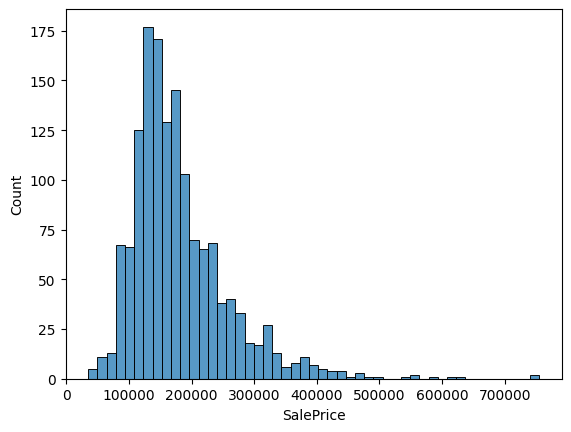

In [3]:
y=houses_train.SalePrice
sns.histplot(y)

**Numeric variables**

In [4]:
numerical_cols = [cname for cname in houses_train.columns if houses_train[cname].dtype in ['int64', 'float64']]

In [5]:
numerical_cols.remove('Id')
numerical_cols.remove('SalePrice')

In [ ]:
for i in numerical_cols:
    plt.figure(figsize=(12, 6))  
    
    plt.subplot(1, 2, 1)  
    sns.scatterplot(x=houses_train[i], y=houses_train['SalePrice'])
    plt.title(f'Scatterplot: SalePrice vs {i}')
        
    plt.subplot(1, 2, 2) 
    sns.histplot(x=houses_train[i])
    plt.title(f'Histogram: {i}')
        
    plt.tight_layout()  
    plt.show()  

**Categorical variables**

In [6]:
categorical_cols = [cname for cname in houses_train.columns if houses_train[cname].dtype == "object"]

In [ ]:
for i in categorical_cols:
    plt.figure(figsize=(12, 6))  
    
    plt.subplot(1, 2, 1)  
    sns.stripplot(x=houses_train[i], y=houses_train['SalePrice'])
    plt.title(f'Stripplot: SalePrice vs {i}')
        
    plt.subplot(1, 2, 2) 
    sns.boxplot(x=houses_train[i], y=houses_train['SalePrice'])
    plt.title(f'Barplot: SalePrice vs {i}')
        
    plt.tight_layout()  
    plt.show()  

# Data cleaning

In [7]:
X=houses_train.copy()

**Numeric variables**

In [40]:
[(c,len(X[c].unique())) for c in numerical_cols]

[('MSSubClass', 15),
 ('LotFrontage', 110),
 ('LotArea', 1073),
 ('OverallQual', 10),
 ('OverallCond', 9),
 ('YearBuilt', 112),
 ('YearRemodAdd', 61),
 ('MasVnrArea', 327),
 ('BsmtFinSF1', 637),
 ('BsmtFinSF2', 144),
 ('BsmtUnfSF', 780),
 ('TotalBsmtSF', 721),
 ('1stFlrSF', 753),
 ('2ndFlrSF', 417),
 ('LowQualFinSF', 24),
 ('GrLivArea', 861),
 ('BsmtFullBath', 4),
 ('BsmtHalfBath', 3),
 ('FullBath', 4),
 ('HalfBath', 3),
 ('BedroomAbvGr', 8),
 ('KitchenAbvGr', 4),
 ('TotRmsAbvGrd', 12),
 ('Fireplaces', 4),
 ('GarageYrBlt', 97),
 ('GarageCars', 5),
 ('GarageArea', 441),
 ('WoodDeckSF', 274),
 ('OpenPorchSF', 202),
 ('EnclosedPorch', 120),
 ('3SsnPorch', 20),
 ('ScreenPorch', 76),
 ('PoolArea', 8),
 ('MiscVal', 21),
 ('MoSold', 12),
 ('YrSold', 5)]

In [415]:
X[numerical_cols].isnull().sum()[X[numerical_cols].isnull().sum()>0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [8]:
my_imputer = SimpleImputer(strategy='median')

X[numerical_cols] = pd.DataFrame(my_imputer.fit_transform(X[numerical_cols]))
X[numerical_cols].columns = houses_train[numerical_cols].columns

**Categorical variables**

In [ ]:
[(c,len(X[c].unique())) for c in categorical_cols]

In [9]:
X[categorical_cols].isnull().sum()[X[categorical_cols].isnull().sum()>0]

Alley           1369
MasVnrType       872
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

We have the variables 'Alley','PoolQC','Fence','MiscFeature' with lots of missing values. 

In [ ]:
for i in ['Alley','PoolQC','Fence','MiscFeature']:
    plt.figure(figsize=(12, 6))  
    plt.subplot(1, 2, 1)  
    sns.stripplot(x=X[i], y=houses_train['SalePrice'])
    plt.title(f'Stripplot: SalePrice vs {i}')
    
    plt.subplot(1, 2, 2) 
    sns.boxplot(x=X[i], y=houses_train['SalePrice'])
    plt.title(f'Barplot: SalePrice vs {i}')
        
    plt.tight_layout()  
    plt.show()  

We are going to ommit them. 

In [10]:
categorical_cols.remove('Alley')
categorical_cols.remove('PoolQC')
categorical_cols.remove('Fence')
categorical_cols.remove('MiscFeature')

In [11]:
my_imputer = SimpleImputer(strategy='most_frequent')

X[categorical_cols] = pd.DataFrame(my_imputer.fit_transform(X[categorical_cols]))
X[categorical_cols].columns = houses_train[categorical_cols].columns

# Feature selection

**Numeric variables**

In [12]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, random_state=35643419)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X[numerical_cols], y)

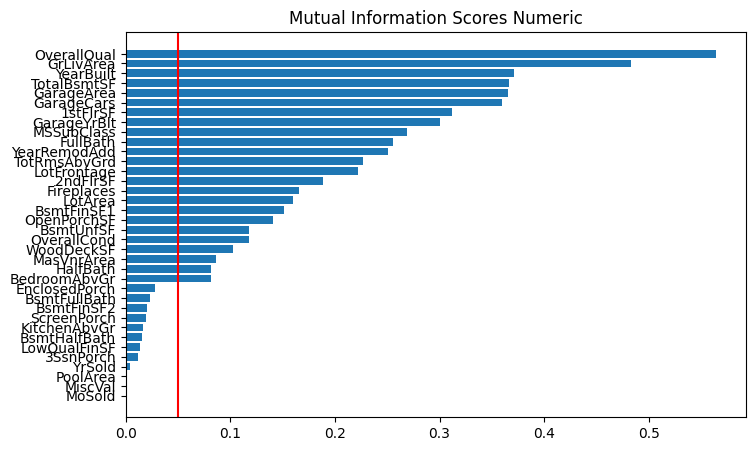

In [13]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores Numeric")
    plt.axvline(x=0.05, color='r')

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [14]:
new_numerical_cols = mi_scores[mi_scores>0.05].index
new_numerical_cols
print('before',len(numerical_cols))
print('after',len(new_numerical_cols))
print('NOT SELECTED VARIABLES:\n')
print(list(set(numerical_cols)-set(new_numerical_cols)))

before 36
after 24
NOT SELECTED VARIABLES:

['BsmtFinSF2', 'BsmtFullBath', 'EnclosedPorch', 'YrSold', 'MoSold', 'PoolArea', 'KitchenAbvGr', 'MiscVal', 'BsmtHalfBath', 'LowQualFinSF', '3SsnPorch', 'ScreenPorch']


**Categorical variables**

In [15]:
#Important to not modify original dataset
X3=X.copy()
for colname in X3.select_dtypes("object"):
    X3[colname], _ = X3[colname].factorize()

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y,random_state=35643419)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X3[categorical_cols], y)
mi_scores[mi_scores>0.05]

ExterQual        0.329593
KitchenQual      0.315726
BsmtQual         0.307575
GarageFinish     0.237554
Foundation       0.194996
HeatingQC        0.161257
Neighborhood     0.130433
GarageType       0.123599
MSZoning         0.113542
BsmtFinType1     0.098317
SaleCondition    0.092847
LotShape         0.090652
SaleType         0.075129
FireplaceQu      0.072471
Exterior2nd      0.067620
MasVnrType       0.062064
CentralAir       0.061587
Name: MI Scores, dtype: float64

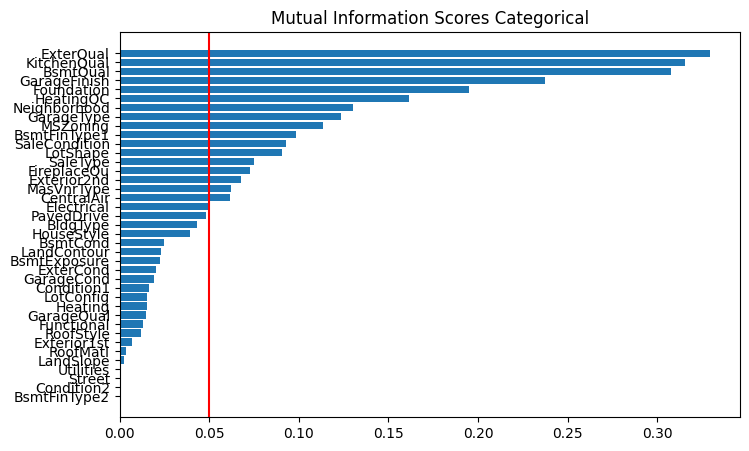

In [16]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores Categorical")
    plt.axvline(x=0.05, color='r')


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [17]:
new_categorical_cols=mi_scores[mi_scores>0.05].index
print('before',len(categorical_cols))
print('after',len(new_categorical_cols))
print('NOT SELECTED VARIABLES:\n')
print(list(set(categorical_cols)-set(new_categorical_cols)))

before 39
after 17
NOT SELECTED VARIABLES:

['Heating', 'HouseStyle', 'GarageQual', 'BsmtFinType2', 'Functional', 'ExterCond', 'Utilities', 'PavedDrive', 'BsmtExposure', 'Electrical', 'Street', 'Condition2', 'RoofMatl', 'RoofStyle', 'GarageCond', 'LotConfig', 'LandSlope', 'Exterior1st', 'BsmtCond', 'BldgType', 'Condition1', 'LandContour']


# Data preprocessing

In [18]:
#In our case new_..._cols they were not list for this reason we do this
X2=X[list(new_categorical_cols)+list(new_numerical_cols)].copy()
X2.head()

,ExterQual,KitchenQual,BsmtQual,GarageFinish,Foundation,HeatingQC,Neighborhood,GarageType,MSZoning,BsmtFinType1,...,Fireplaces,LotArea,BsmtFinSF1,OpenPorchSF,BsmtUnfSF,OverallCond,WoodDeckSF,MasVnrArea,HalfBath,BedroomAbvGr
0,Gd,Gd,Gd,RFn,PConc,Ex,CollgCr,Attchd,RL,GLQ,...,0.0,8450.0,706.0,61.0,150.0,5.0,0.0,196.0,1.0,3.0
1,TA,TA,Gd,RFn,CBlock,Ex,Veenker,Attchd,RL,ALQ,...,1.0,9600.0,978.0,0.0,284.0,8.0,298.0,0.0,0.0,3.0
2,Gd,Gd,Gd,RFn,PConc,Ex,CollgCr,Attchd,RL,GLQ,...,1.0,11250.0,486.0,42.0,434.0,5.0,0.0,162.0,1.0,3.0
3,TA,Gd,TA,Unf,BrkTil,Gd,Crawfor,Detchd,RL,ALQ,...,1.0,9550.0,216.0,35.0,540.0,5.0,0.0,0.0,0.0,3.0
4,Gd,Gd,Gd,RFn,PConc,Ex,NoRidge,Attchd,RL,GLQ,...,1.0,14260.0,655.0,84.0,490.0,5.0,192.0,350.0,1.0,4.0


**Pairing levels of categorical variables of train and test samples**

 It is time to modify our train sample using our test sample in order that there are coherence between both sets. We are going to analyze the test sample in order that categorical variables have exactly the same levels in both sides. If we do not do this now, when we would like to fit our model, there will be problems. 
 
  At the same time we are going to imputate numeric and categorical values in our test set. 

In [19]:
houses_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
houses_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [20]:
X_test=houses_test[list(new_numerical_cols)+list(new_categorical_cols)].copy()
X_test.head()

,OverallQual,GrLivArea,YearBuilt,TotalBsmtSF,GarageArea,GarageCars,1stFlrSF,GarageYrBlt,MSSubClass,FullBath,...,GarageType,MSZoning,BsmtFinType1,SaleCondition,LotShape,SaleType,FireplaceQu,Exterior2nd,MasVnrType,CentralAir
0,5,896,1961,882.0,730.0,1.0,896,1961.0,20,1,...,Attchd,RH,Rec,Normal,Reg,WD,NaN,VinylSd,NaN,Y
1,6,1329,1958,1329.0,312.0,1.0,1329,1958.0,20,1,...,Attchd,RL,ALQ,Normal,IR1,WD,NaN,Wd Sdng,BrkFace,Y
2,5,1629,1997,928.0,482.0,2.0,928,1997.0,60,2,...,Attchd,RL,GLQ,Normal,IR1,WD,TA,VinylSd,NaN,Y
3,6,1604,1998,926.0,470.0,2.0,926,1998.0,60,2,...,Attchd,RL,GLQ,Normal,IR1,WD,Gd,VinylSd,BrkFace,Y
4,8,1280,1992,1280.0,506.0,2.0,1280,1992.0,120,2,...,Attchd,RL,ALQ,Normal,IR1,WD,NaN,HdBoard,NaN,Y


In [535]:
X_test.isnull().sum()[X_test.isnull().sum()>0]

TotalBsmtSF       1
GarageArea        1
GarageCars        1
GarageYrBlt      78
LotFrontage     227
BsmtFinSF1        1
BsmtUnfSF         1
MasVnrArea       15
KitchenQual       1
BsmtQual         44
GarageFinish     78
GarageType       76
MSZoning          4
BsmtFinType1     42
SaleType          1
FireplaceQu     730
Exterior2nd       1
MasVnrType      894
dtype: int64

In [21]:
my_imputer = SimpleImputer(strategy='median')

X_test[new_numerical_cols] = pd.DataFrame(my_imputer.fit_transform(X_test[new_numerical_cols]))
X_test[new_numerical_cols].columns = houses_test[new_numerical_cols].columns

In [22]:
my_imputer = SimpleImputer(strategy='most_frequent')

X_test[new_categorical_cols] = pd.DataFrame(my_imputer.fit_transform(X_test[new_categorical_cols]))
X_test[new_categorical_cols].columns = houses_test[new_categorical_cols].columns

In [23]:
for c in new_categorical_cols:
    print(c)
    #print(list(X2[c].unique()))
    #print(list(X_test[c].unique()))
    print(set(list(X2[c].unique()))-set(list(X_test[c].unique())))

ExterQual
set()
KitchenQual
set()
BsmtQual
set()
GarageFinish
set()
Foundation
set()
HeatingQC
set()
Neighborhood
set()
GarageType
set()
MSZoning
set()
BsmtFinType1
set()
SaleCondition
set()
LotShape
set()
SaleType
set()
FireplaceQu
set()
Exterior2nd
{'Other'}
MasVnrType
set()
CentralAir
set()


In [24]:
#Index from the dataset that has 'Other' as 'Exterior2nd'
X3=X2[X2['Exterior2nd']!='Other'].copy()
print(X3.shape)

(1459, 41)


In [25]:
y2=y.copy()
a=list(X2[X2['Exterior2nd']=='Other'].index)

In [26]:
y2.drop(index=a,inplace=True)
len(y2)

1459

We are going to see now if this worked. 

In [27]:
for c in new_categorical_cols:
    print(c)
    #print(list(X3[c].unique()))
    #print(list(X_test[c].unique()))
    print(set(list(X3[c].unique()))-set(list(X_test[c].unique())))

ExterQual
set()
KitchenQual
set()
BsmtQual
set()
GarageFinish
set()
Foundation
set()
HeatingQC
set()
Neighborhood
set()
GarageType
set()
MSZoning
set()
BsmtFinType1
set()
SaleCondition
set()
LotShape
set()
SaleType
set()
FireplaceQu
set()
Exterior2nd
set()
MasVnrType
set()
CentralAir
set()


**One hot encoding**

In [28]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

OH_cols = pd.DataFrame(OH_encoder.fit_transform(X3[new_categorical_cols]))

OH_cols

OH_cols.index = X3.index
OH_cols

X3.drop(new_categorical_cols, axis=1, inplace=True)

X3 = pd.concat([X3, OH_cols], axis=1)

X3.columns = X3.columns.astype(str)

In [29]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

OH_cols = pd.DataFrame(OH_encoder.fit_transform(X_test[new_categorical_cols]))

OH_cols

OH_cols.index = X_test.index
OH_cols

X_test.drop(new_categorical_cols, axis=1, inplace=True)

X_test = pd.concat([X_test, OH_cols], axis=1)

X_test.columns = X_test.columns.astype(str)

In [30]:
#Comprobation to see if they have the same dimension
print(X3.shape)
print(X_test.shape)

(1459, 136)
(1459, 136)


**COMMENT**: we are going to use CV scores to tune the models in a grid. For this reason we are not going to divide our training sample in validation and train. 

# Models 

## Decision tree

In [31]:
dtm = DecisionTreeRegressor(max_depth= 10, max_leaf_nodes= 10, min_samples_split= 3,random_state=35643419)

**CV grid search** 

In [ ]:
'''
param_grid = {
    'max_depth': [10,15],
    'min_samples_split': [3, 10],
    'max_leaf_nodes': [7,10,15]
}

grid_search = GridSearchCV(estimator=dtm, param_grid=param_grid, scoring='neg_mean_absolute_error',cv=5, n_jobs=-1)


grid_search.fit(X2, y)
'''

In [ ]:
'''
print("Best Parameters: ", grid_search.best_params_)
print("Best scoring: {:.2f}".format(abs(grid_search.best_score_)))
#Best Parameters:  {'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_split': 3}
#Best scoring: 30024.82
'''

## Random forest 

In [32]:
rfm = RandomForestRegressor(max_depth= 30, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 250,random_state=35643419)

**CV grid search**

In [ ]:
'''
param_grid = {
    'n_estimators': [200,250,300,350,400,450],
    'max_depth': [10,15,20,25,30,35],
    'min_samples_split': [3],
    'min_samples_leaf': [1],
}

grid_search = GridSearchCV(estimator=rfm, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

grid_search.fit(X2, y)
'''

In [ ]:
#print("Best Parameters: ", grid_search.best_params_)
#print("Best scoring: {:.2f}".format(abs(grid_search.best_score_)))


#Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}
#Best scoring: 17578.39

#Best Parameters:  {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 250}
#Best scoring: 17398.46

#Best Parameters:  {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 350}
#Best scoring: 17400.02

#Best Parameters:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 250}
#Best scoring: 17395.16

## XGBoost

In [33]:
xgbm = XGBRegressor(reg_lambda= 0.5, learning_rate= 0.1, max_depth= 3, n_estimators= 300,random_state=35643419)

**CV grid search**

In [ ]:
'''
param_grid = {
    'n_estimators': [300,350],
    'max_depth': [3],
    'learning_rate': [0.1],
    'lambda':[0.5,0.6,0.7]
    #'alpha':[0.5,0.6,0.7]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgbm, param_grid=param_grid,scoring='neg_mean_absolute_error',cv=5, n_jobs=-1)

# Perform grid search on the data
grid_search.fit(X2, y)
'''

In [ ]:
# Print the best parameters and the corresponding accuracy score
#print("Best Parameters: ", grid_search.best_params_)
#print("Best Accuracy: {:.2f}".format(grid_search.best_score_))

#Best Parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
#Best Accuracy: -15747.98

#Best Parameters:  {'alpha': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
#Best Accuracy: -15746.38

#Best Parameters:  {'alpha': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
#Best Accuracy: -15731.37

#Best Parameters:  {'alpha': 0.5, 'lambda': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
#Best Accuracy: -15723.93

#Best Parameters:  {'lambda': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
#Best Accuracy: -15723.93

## Voting regressor 

In [34]:
#k_folds=5

voting_regressor = VotingRegressor(estimators=[('dt', dtm), ('rf', rfm), ('xgb', xgbm)])

#cross_val_scores = cross_val_score(voting_regressor, X3, y2, cv=k_folds,scoring='neg_mean_absolute_error')
#print("Cross-Validation Scores:", abs(cross_val_scores))
#print("Average Accuracy: {:.2f}".format(np.mean(abs(cross_val_scores))))

## Gradient boosting 

In [436]:
gb = GradientBoostingRegressor(random_state=35463419)

**CV grid search**

In [441]:
'''
param_grid = {
    'n_estimators': [250], 
    'learning_rate': [0.1],  
    'max_depth': [4],
    'min_samples_split':[2,5,7]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid,scoring='neg_mean_absolute_error',cv=5, n_jobs=-1)

# Perform grid search on the data
grid_search.fit(X3, y2)
'''

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=35463419),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [4],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [250]},
             scoring='neg_mean_absolute_error')

In [442]:
#print("Best Parameters: ", grid_search.best_params_)
#print("Best Accuracy: {:.2f}".format(grid_search.best_score_))

#Best Parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 250}
#Best Accuracy: -15851.23

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 250}
Best Accuracy: -15851.23


## Ada boost 

In [449]:
ab = AdaBoostRegressor(random_state=35643419)

In [447]:
'''
param_grid = {
    'n_estimators': [100],  
    'learning_rate': [0.2] 
}

grid_search = GridSearchCV(estimator=ab, param_grid=param_grid,scoring='neg_mean_absolute_error',cv=5, n_jobs=-1)

grid_search.fit(X3, y2)
'''

GridSearchCV(cv=5, estimator=AdaBoostRegressor(random_state=35643419),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2], 'n_estimators': [50, 100]},
             scoring='neg_mean_absolute_error')

In [448]:
#print("Best Parameters: ", grid_search.best_params_)
#print("Best Accuracy: {:.2f}".format(grid_search.best_score_))

#Best Parameters:  {'learning_rate': 0.2, 'n_estimators': 100}
#Best Accuracy: -23220.07

Best Parameters:  {'learning_rate': 0.2, 'n_estimators': 100}
Best Accuracy: -23220.07


**BEST PERFORMANCE**

In [36]:
k_folds = 7

for i in [dtm,rfm,xgbm,voting_regressor]:
    cross_val_scores = cross_val_score(i, X3, y2, cv=k_folds,scoring='neg_mean_absolute_error')
    print("Cross-Validation Scores:", abs(cross_val_scores))
    print("Average Accuracy: {:.2f}".format(np.mean(abs(cross_val_scores))))

Cross-Validation Scores: [31327.84644985 26208.91828054 29100.78738319 32171.2689605
 26425.53899507 31542.16392824 30544.0773818 ]
Average Accuracy: 29617.23
Cross-Validation Scores: [17756.22565962 16806.53231399 16985.66820169 18836.73528623
 14729.89982205 18425.67781936 18048.06009269]
Average Accuracy: 17369.83
Cross-Validation Scores: [15402.02891373 14888.88995215 16805.60687051 17019.24797175
 13673.70582933 15846.83387169 15189.45688101]
Average Accuracy: 15546.54
Cross-Validation Scores: [19510.70496004 16369.27302732 18915.06055927 20800.27905696
 15837.60107772 19379.69069799 19754.17422253]
Average Accuracy: 18652.40


# Submission

In [38]:
xgbm = XGBRegressor(reg_lambda= 0.5, learning_rate= 0.1, max_depth= 3, n_estimators= 300,random_state=35643419)

xgbm.fit(X3, y2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=35643419, ...)

In [39]:
features = X3.columns
feature_importances=xgbm.feature_importances_

for feature, importance in zip(X3.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

#plt.figure(figsize=(10, 6))
#plt.bar(features, feature_importances)
#plt.xlabel('Features')
#plt.ylabel('Importance')
#plt.title('Feature Importances')
#plt.xticks(rotation=45)
#plt.show()

Feature: OverallQual, Importance: 0.15967783331871033
Feature: GrLivArea, Importance: 0.03222274035215378
Feature: YearBuilt, Importance: 0.008566624484956264
Feature: TotalBsmtSF, Importance: 0.027697963640093803
Feature: GarageArea, Importance: 0.0026612766087055206
Feature: GarageCars, Importance: 0.12741564214229584
Feature: 1stFlrSF, Importance: 0.012933306396007538
Feature: GarageYrBlt, Importance: 0.0038105749990791082
Feature: MSSubClass, Importance: 0.0008816773188300431
Feature: FullBath, Importance: 0.05105103179812431
Feature: YearRemodAdd, Importance: 0.014940573833882809
Feature: TotRmsAbvGrd, Importance: 0.004368823487311602
Feature: LotFrontage, Importance: 0.0014828890562057495
Feature: 2ndFlrSF, Importance: 0.024498097598552704
Feature: Fireplaces, Importance: 0.026539893820881844
Feature: LotArea, Importance: 0.006088805850595236
Feature: BsmtFinSF1, Importance: 0.01936369016766548
Feature: OpenPorchSF, Importance: 0.001499122940003872
Feature: BsmtUnfSF, Importance:

In [ ]:
preds_xgb = xgbm.predict(X_test)

In [ ]:
output = pd.DataFrame({'Id': houses_test.Id, 'SalePrice': preds_xgb})
output.to_csv('submission1.csv', index=False)